# Homework 1

Jonathan Elsner \
October 4th, 2024

In [1]:
import pandas as pd

import numpy as np
from numpy.polynomial import Polynomial

import matplotlib.pyplot as plt

## Problem 1

### Part 1

<img src="./problem1-1.jpg" width=400></img>

### Part 2

Using hydrostatic bounds, we can derive the water pressure as a function of height, and therefore time:

$$
\begin{split}
\frac{\partial P}{\partial z} &= -\rho g \\
\int_{z=h(t)}^{h_0} \frac{\partial P}{\partial z} dz &= \int_{z=h(t)}^{z=h_0} -\rho g dz \\
P &= - \rho g |_{z=h(t)}^{z=h_0} + P_\text{atm}\\
P &= \rho g (h(t) - h_0) + P_\text{atm}
\end{split}
$$

And the potential energy at the surface is density times gravity times the height difference:

$$ PE_\text{surface} = \rho g (h(t) - h_0) $$

Calculating both, we have:

In [50]:
water_density = 997 # kg/m^3, water density
P_atm = 101325
g = 9.81 # gravity, m/s^2
P = water_density * g * (0.445 - 0.104) + P_atm
print(f'Pressure from water: {P / P_atm:0.3f} atmospheres')

Pressure from water: 1.033 atmospheres


In [51]:
PE_surf = water_density * g * (0.445 - 0.104)
print(f'Potential Energy at surface: {PE_surf} J/m^3')

Potential Energy at surface: 3335.17437 J/m^3



### Part 3

Simplifying the system by setting the kinetic energy of a parcel of water at the bottom of the tube equal to the potential energy of a parcel at the top of the tube, we get the water velocity:

$$
\begin{split}
\frac{1}{2} \rho U^2 &= KE = PE_\text{surface} \\
\frac{1}{2} \rho U^2 &= \rho g (h(t) - h_0) \\
U^2 &= 2g (h(t) - h_0) \\
U &= \sqrt{2g(h(t) - h_0)}
\end{split}
$$

From here, we can get the volume transport by multiplying this quantity by the cross-sectional area of the hole: 

$$ V = \pi r_h^2 \sqrt{2g(h(t) - h_0)} $$

### Part 4

Taking the change in height to be the volume transport divided by the cross-sectional area of the pipe, we can derive an ODE and solve for the height of the water as a function of time:

$$
\begin{split}
\frac{dh}{dt} &= \frac{V}{A_p} \\
&= \frac{\pi r_h^2}{\pi r_p^2} \sqrt{2g(h - h_0)} \\
\int \frac{dh}{\sqrt{h-h_0}} &= \frac{\sqrt{2g} r_h^2}{r_p^2} \int dt \\
2\sqrt{h - h_0} &= \frac{\sqrt{2g}r_h^2}{r_p^2} t + C \\
h(t) &= \frac{gr_h^4}{2r_p^4}(t+C)^2 + h_0
\end{split}
$$

Taking $C = - t_f$ we get

$$  h(t) = \frac{gr_h^4}{2r_p^4}(t - t_f)^2 + h_0 $$

where $t_f$ is the time at which the water reaches the hole and $h_0$ is the height of the hole.



### Part 5

First let's load the data from the lab.

In [2]:
data = pd.read_csv('lab1-water-spout-measurements.csv', index_col='time (s)')
data.dropna(inplace=True)
data

,height (cm)
time (s),
0,44.5
20,43.0
40,42.0
60,40.8
80,39.6
...,...
1340,10.4
1360,10.4
1380,10.4


then convert to meters, so everything is in base units.

In [3]:
data['height (m)'] = data['height (cm)'] / 100

Now we can fit the data to a quadratic curve to match the equation we derived in the previous part.

In [4]:
poly = Polynomial.fit(data.index, data['height (m)'], deg=2).convert()

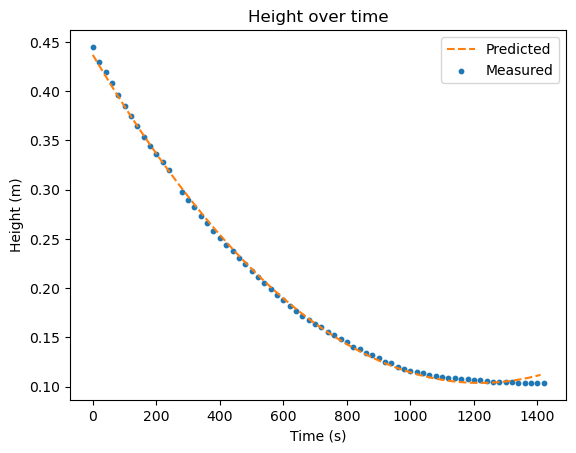

In [5]:
ax = plt.gca()

x = np.arange(0, 1420, 10)
y = poly(x)
ax.plot(x, y, linestyle='--', color='tab:orange', label='Predicted')

ax.scatter(data.index, data['height (m)'], s=10, label='Measured')

ax.set_title('Height over time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Height (m)')
ax.legend()

plt.show()

Looks pretty good. The fitted second degree polynomial and R-squared are below:

In [6]:
poly

Polynomial([ 4.36924060e-01, -5.46673934e-04,  2.24202701e-07], domain=[-1.,  1.], window=[-1.,  1.], symbol='x')

($x$ is time here since you can't customize variables with NumPy Polynomials)

In [7]:
from sklearn.metrics import r2_score

r2 = r2_score(data['height (m)'], poly(data.index))
print(f'R² = {r2}')

R² = 0.9991633480643921


#### Predicted hole radius

In [8]:
a = poly.coef[2] # coefficient of t^2

g = 9.81 # gravity converted to cgs
r_p = 5.5 / 100 / 2 # pipe radius
r_h = r_p * np.power(2*a/g, 0.25)
print(f'{r_h:0.5f} m')

0.00040 m


This is the predicted radius in meters. This ends up being 0.4mm. We estimated that the hole has a diameter of approximately 1mm, so this is logical.

### Part 6

For the surface tension at an opening, we have

$$ P_\rho = \frac{2 \sigma}{r_h} $$

Since the hole is small, we will assume that $\alpha$ is close to zero. From this, we can conclude that the pressure due to surface tension at the hole is:


In [23]:
sigma = 0.07 # Surface tension of water at room temperature
P_surface_tension = 2 * sigma / r_h
print(f'{P_surface_tension:0.3f} N/m^2')

348.173 N/m^2


Then the pressure at the hole is:

$$ P_\text{hydro} = P_\text{atm} + P_\rho $$

If we want to solve for $h_f$, using hydrostatic bounds, we have:

$$\begin{split}
\rho g (h_f - h_0) &= \sum P \\
h_f &= \frac{\sum P}{\rho g} + h_0
\end{split}$$

Retrieving the predicted height of the hole from the fitted polynomial and solving for the predicted final height, we get:

In [29]:
t_f = -poly.coef[1] / (2*poly.coef[2]) # Vertex of curve -b/2a, when water reaches the hole
h_0 = poly(t_f) # Predicted height of the hole
P_0 = P_atm = 101325 # atmospheric pressure in Pa
water_density = 997 # kg/m^3, density of water
g = 9.81 # gravity

h_f = P_surface_tension / (water_density * g) + h_0
print(f'{h_f*100:.3f} cm')

13.928 cm


Compared to the predicted height of the hole:

In [31]:
print(f'{h_0*100:0.3f} cm')

10.368 cm


The difference is about 3.5 cm, which is the right order of magnitude but a little more than we observed in lab (about 1cm).

## Problem 2

### Parts 1 and 2

<img src="./problem2-3and4.jpg" width=800></image>

At first we expect the pressure inside the tube to be equal to atmospheric pressure since we simply separated that volume of air from the rest of the atmosphere. Then while the candle is burning, we expect the pressure to rise ever so slightly since we are adding heat to the system. Then at the end, when the candle has burned out, we expect the pressure to drop, since the temperature has returned to room temperature, and further the water produced by the combustion reaction to precipitate out of the air in the tube, lowering the density of the air. This is what causes the water level to ultimately rise visibly.

### Part 3

Let's calculate the final air pressure in the bottle using $P/P_0 = \text{exp}(-zg/RT_0)$.

In [3]:
g = 9.81 # gravity
R = 287 # R_specific for air
T_0 = 295 # Room temp in kelvin
P_0 = P_atm = 101325 # atmospheric pressure in Pa

def pressure(z):
    return P_0 * np.exp(-z / (R * T_0 / g))

P = pressure(0.018) # Pressure after the water rose 1.8cm
print(f'{P:0.3f} Pa')

101324.789 Pa


Cool, but that's really close to atmospheric pressure, so it's hard to tell. 
As a ratio of atmospheric pressure:

In [4]:
P / P_atm

0.999997914370568

So the final pressure in the tube is 99% of atmospheric pressure. Slightly less than atmospheric, as we would expect for the water to rise.

Now calculating the density using $P = \rho R T$:

In [219]:
final_density = P / (R * T_0)
print(f'{final_density:0.5f} kg/m^3')

1.19653 kg/m^3


This is the final density of the gas inside the tube. We expect this to be slightly lower than the density of air normally, which is:

In [220]:
air_density = P_atm / (R * T_0)
f'{air_density:0.5f} kg/m^3' 

'1.19678 kg/m^3'

As a ratio:

In [208]:
final_density / air_density

0.999791458587092

Slightly smaller, as we expected.

### Part 4

Given that density is defined as mass per unit volume, and that the rise in fluid in the bottle decreases the volume of the air inside it, we would expect the density of the air to increase, since $ \rho = m/V $. However, this is inconsistent with our findings in the last part, where we found that the density actually slightly decreases (along with pressure).

However, as mentioned in part two, the combustion reaction produces water vapor that condenses, hence the number of moles of gas decreases, and by the ideal gas law

$$\begin{split}
P &= \left(\frac{m}{V}\right)\left(\frac{R}{n k_0}\right)T \\
\rho &= \frac{nk_0P}{T}
\end{split}$$

lowering the density of the gas inside the cylinder.